---
title: "Evaluacion del rendimiento de modelos"
date: 2022-05-03T17:30:50+02:00
tags: [dummy, baseline, ]
categories: [tutoriales]
---

En anteriores posts vimos el framework general de validación cruzada y su uso para evaluar el rendimiento de modelos. Sin embargo, es importante tener en cuenta que algunos elementos de la validación cruzada deben decidirse en función de la naturaleza del problema: (i) la estrategia de validación cruzada y (ii) las métricas de evaluación. Además, siempre es bueno comparar el rendimiento de los modelos respecto de alguna línea base.

En este post presentaremos ambos aspectos y ofreceremos intuiciones e ideas de cuándo usar una estrategia de validación cruzada y métrica específicas. Además, también daremos algunas ideas sobre cómo comparar un modelo con alguna línea base.

Como objetivos generales intentaremos:

+ comprender la necesidad de usar una estrategia adecuada de validación cruzada dependiendo de los datos;
+ obtener las intuiciones y principios que hay detrás del uso de la validación cruzada anidada cuando el modelo necesita ser evaluado y optimizado;
+ comprender las diferencias entre las métricas de regresión y clasificación;
+ comprender las diferencias entre métricas.

# Comparación del rendimiento del modelo con una línea base simple

Vamos a ver cómo comparar el rendimiento de generalización de un modelo con una mínima linea base. En regresión, podemos usar la clase `DummyRegressor` para predecir el valor medio del objetivo observado en el conjunto de entrenamiento sin usar las variables de entrada.

Demostraremos cómo calcular la puntuación de un modelo de regresión y compararlo con una línea base en el dataset de viviendas de California.

In [127]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
y *= 100  # reescala el objetivo en k$

En todas las evaluaciones usaremos un divisor de validación cruzada `ShuffleSplit` con el 20% de los datos reservados para validación.

In [128]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

Empezaremos ejecutando la validación cruzada para un simple árbol de decisión regresor, que es nuestro modelo de interés. Además, almacenaremos el error de prueba en un objeto serie de pandas para hacer más sencillo dibujar los resultados.

In [129]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

regressor = DecisionTreeRegressor()
cv_results_tree_regressor = cross_validate(
    regressor, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
)

errors_tree_regressor = pd.Series(
    -cv_results_tree_regressor["test_score"], name="Arbol decisión regresor"
)
errors_tree_regressor.describe()

count    30.000000
mean     45.741313
std       1.260054
min      43.200330
25%      44.821907
50%      45.881654
75%      46.675914
max      48.212643
Name: Arbol decisión regresor, dtype: float64

Luego, evaluamos nuestra línea base.  Esta línea base se denomina regresor dummy. Este regresor dummy siempre predecirá la media del objetivo calculada en la variable objetivo de entrenamiento. Por lo tanto, el regresor dummy no usa ninguna información de las variables de entrada almacenadas en el dataframe llamado `X`.

In [130]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
result_dummy = cross_validate(
    dummy, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
)
errors_dummy_regressor = pd.Series(
    -result_dummy["test_score"], name="Regresor dummy"
)
errors_dummy_regressor.describe()

count    30.000000
mean     91.140009
std       0.821140
min      89.757566
25%      90.543652
50%      91.034555
75%      91.979007
max      92.477244
Name: Regresor dummy, dtype: float64

Ahora dibujaremos los errores de prueba de la validación cruzada para la línea base usando la media del objetivo y el actual árbol de decisión regresor.

In [131]:
all_errors = pd.concat(
    [errors_tree_regressor, errors_dummy_regressor],
    axis=1,
)
all_errors

,Arbol decisión regresor,Regresor dummy
0,47.230613,90.713153
1,46.907604,90.539353
2,44.125476,91.941912
3,43.200330,90.213912
4,48.212643,92.015862
5,45.013750,90.542490
6,43.673512,89.757566
7,44.610531,92.477244
8,45.794589,90.947952
9,44.757960,91.991373


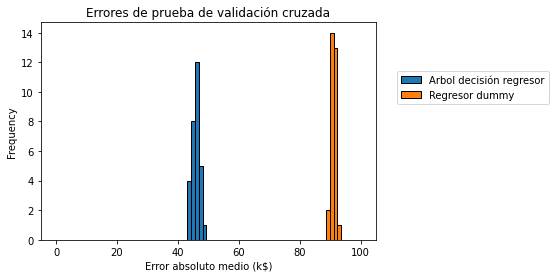

In [132]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.linspace(start=0, stop=100, num=80)
all_errors.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Error absoluto medio (k$)")
_ = plt.title("Errores de prueba de validación cruzada")

Vemos que el rendimiento de generalización de nuestro ábol de decisión está lejos de ser perfecto: las predicciones del precio tiene aproximadamente un márgen de error de 45000 dólares de media. Sin embargo, es mucho mejor que el margen de error de la línea base. Por tanto, esto confirma que es posible predecir mucho mejor el precio de la vivienda usando un modelo que tenga en cuenta los valores de las variables de entrada (localización de la propiedad, tamaño, ingresos del vecindario, etc.). Dicho modelo hace predicciones más formadas y, aproximadamente, divide la tasa de error por la mitad comparado con la línea base que ignora las variables de entrada.

Observemos que hemos usado la media del precio como predicción de línea base. Podríamos haber usado en su lugar la mediana. Véase la documentación online de la clase [`sklearn.dummy.DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) para otras opciones. Para este ejemplo en particular, no existe mucha diferencia entre usar la media en lugar de la mediana, pero este podría ser el caso de un dataset con valores atípicos extremos.

## Ejercicio

Vamos a poner en práctica lo aprendido hasta ahora. Definiremos una línea base con un clasificador dummy y lo usaremos como referencia para evaluar el rendimiento predictivo relativo de un modelo de interés dado.

Ilustraremos dicha línea base con la ayuda del dataset del censo de adultos, usando únicamente las variables numéricas, por simplicidad.

In [133]:
adult_census = pd.read_csv("../data/adult-census-numeric-all.csv")
X, y = adult_census.drop(columns="class"), adult_census["class"]

Primero definiremos una estrategia de validación cruzada con `ShuffleSplit` tomando la mitad de las muestras como prueba en cada ciclo. Usaremos 10 ciclos de validación cruzada.

In [134]:
cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0)

Lo siguiente es crear un pipeline de machine learning compuesto por un transformador para estandarizar los datos seguido por un clasificador de regresión logística.

In [135]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

classifier = make_pipeline(StandardScaler(), LogisticRegression())


Calculemos ahora las puntuaciones de prueba de validación cruzada para el clasificador en este dataset y almacenaremos los resultados en una Series de panda.

In [136]:
from sklearn.model_selection import cross_validate

cv_results_logistic_regression = cross_validate(
    classifier, X, y, cv=cv, n_jobs=-1)

test_score_logistic_regression = pd.Series(
    cv_results_logistic_regression["test_score"], name="Regresión logística"
)
test_score_logistic_regression

0    0.815937
1    0.813849
2    0.815036
3    0.815569
4    0.810982
5    0.814709
6    0.813112
7    0.810327
8    0.812416
9    0.816388
Name: Regresión logística, dtype: float64

Ahora calcularemos las puntuaciones de validación cruzada de un clasificador dummy que prediga constantemente la clase más frecuente observada en el conjunto de entrenamiento. Almacenaremos los resultados en un Series de panda.

In [137]:
from sklearn.dummy import DummyClassifier

dummy_most_frequent = DummyClassifier(strategy="most_frequent")
result_dummy = cross_validate(
    dummy_most_frequent, X, y, cv=cv, n_jobs=-1
)
test_dummy_most_frequent = pd.Series(
    result_dummy["test_score"], name="Most-frequent dummy"
)
test_dummy_most_frequent

0    0.760329
1    0.756808
2    0.759142
3    0.760739
4    0.761681
5    0.761885
6    0.757463
7    0.757176
8    0.761885
9    0.763114
Name: Most-frequent dummy, dtype: float64

Ahora que hemos recopilado los resultados tanto de la línea base como del modelo, vamos a concatenar las puntuaciones de prueba como columnas en un dataframe de pandas.

In [138]:
all_scores = pd.concat(
    [test_score_logistic_regression, test_dummy_most_frequent],
    axis=1,
)
all_scores

,Regresión logística,Most-frequent dummy
0,0.815937,0.760329
1,0.813849,0.756808
2,0.815036,0.759142
3,0.815569,0.760739
4,0.810982,0.761681
5,0.814709,0.761885
6,0.813112,0.757463
7,0.810327,0.757176
8,0.812416,0.761885
9,0.816388,0.763114


Lo siguiente que haremos será dibujar el histograma de las puntuaciones de prueba de validación cruzada para ambos modelos con la ayuda de la [función de dibujado incorporada en pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#histograms). ¿Qué conclusiones obtenemos de los resultados?

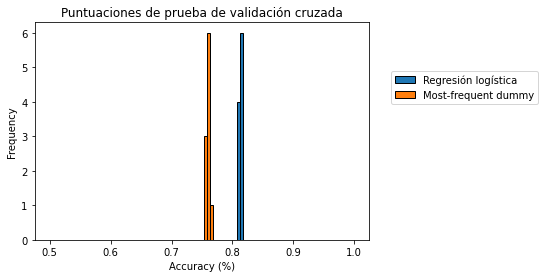

In [139]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.linspace(start=0.5, stop=1.0, num=100)
all_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Puntuaciones de prueba de validación cruzada")

Observamos que los dos histogramas están bien separados. Por lo tanto el clasificador dummy con la estrategia `most_frequent` tiene mucha menos precisión que el clasificador de regresión logística. Podemos concluir que el modelo de regresión logística puede encontrar satisfactoriamente información predictiva en las variables de entrada para mejorar la línea base.

Por último, vamos a cambiar la estrategia del clasificador dummy a `"stratified"` y calcularemos los resultados. De igual forma, calcularemos las puntuaciones para la `strategy="uniform"` y después dibujaremos la distribución conjuntamente con los otros resultados.

¿Estas nuevas líneas base son mejores que la previa? ¿Por qué es este el caso?

Podemos consultar la documentación de [`sklearn.dummy.DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) para conocer el significado de estas estrategias.

In [140]:
dummy_stratified = DummyClassifier(strategy="stratified")
result_dummy_stratified = cross_validate(
    dummy_stratified, X, y, cv=cv, n_jobs=-1
)
test_dummy_stratified = pd.Series(
    result_dummy_stratified["test_score"], name="Stratified dummy"
)
test_dummy_stratified

0    0.641088
1    0.634863
2    0.637812
3    0.637935
4    0.640678
5    0.642685
6    0.639450
7    0.640760
8    0.638999
9    0.635805
Name: Stratified dummy, dtype: float64

In [141]:
dummy_uniform = DummyClassifier(strategy="uniform")
result_dummy_uniform = cross_validate(
    dummy_uniform, X, y, cv=cv, n_jobs=-1
)
test_dummy_uniform = pd.Series(
    result_dummy_uniform["test_score"], name="Uniform dummy"
)
test_dummy_uniform

0    0.498096
1    0.498628
2    0.503296
3    0.500798
4    0.499488
5    0.503010
6    0.501331
7    0.496458
8    0.503296
9    0.502314
Name: Uniform dummy, dtype: float64

In [142]:
all_scores = pd.concat(
    [test_score_logistic_regression,
     test_dummy_most_frequent,
     test_dummy_stratified,
     test_dummy_uniform,],
    axis=1,
)
all_scores

,Regresión logística,Most-frequent dummy,Stratified dummy,Uniform dummy
0,0.815937,0.760329,0.641088,0.498096
1,0.813849,0.756808,0.634863,0.498628
2,0.815036,0.759142,0.637812,0.503296
3,0.815569,0.760739,0.637935,0.500798
4,0.810982,0.761681,0.640678,0.499488
5,0.814709,0.761885,0.642685,0.503010
6,0.813112,0.757463,0.639450,0.501331
7,0.810327,0.757176,0.640760,0.496458
8,0.812416,0.761885,0.638999,0.503296
9,0.816388,0.763114,0.635805,0.502314


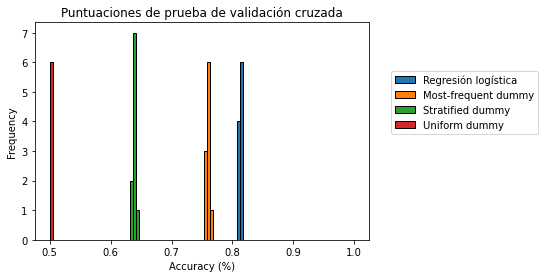

In [143]:
bins = np.linspace(start=0.5, stop=1.0, num=100)
all_scores.plot.hist(bins=bins, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Accuracy (%)")
_ = plt.title("Puntuaciones de prueba de validación cruzada")

Vemos que al usar `strategy="stratified"` los resultados son mucho peores que con la estrategia `most_frequent`. Dado que las clases están desbalanceadas, predecir la más frecuente implica que acertaremos en la proporción de esa clase (aproximadamente el 75% de las muestras), es decir, el 75% de las veces. Sin embargo, la estrategia `"stratified"` generará predicciones aleatoriamente respetando la distribución de las clases del conjunto de entrenamiento, lo que dará como resultado algunas predicciones incorrectas, incluso para la clase más frecuente, por lo tanto obtenemos una precisión menor.

Esto es aún más cierto para `strategy="uniform"`: esta estrategia asigna etiquetas de clase uniformemente al azar. Por lo tanto, en un problema de clasificación binaria, la precisión de validación cruzada es del 50% de media, por lo cual es la más débil de las tres líneas base dummy.

Nota: se podría argumentar que las estrategias `"uniform"` y `"stratified"` son maneras válidas de definir un "nivel de referencia" de la precisión de una línea base para el problema de clasificación, debido a que hacen predicciones "al azar".

Otra forma de definir un nivel de azar podría ser usando la utilidad de scikit-learn [sklearn.model_selection.permutation_test_score](https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html). En lugar de usar un clasificador dummy, esta función compara la precisión de validación cruzada de un modelo de interés con la precisión de validación cruzada de este mismo modelo pero entrenado en etiquetas de clase permutadas aleatoriamente. Por lo tanto, `permutation_test_score` define un nivel de azar que depende de la elección de la clase y los hiperparámetros del estimador de interés. Cuando entrenamos en tales etiquetas permutadas aleatoriamente, muchos estimadores de machine learning terminan comportándose aproximadamente como `DummyClassifier(strategy="most_frequent")`, prediciendo siempre la clase mayoritaria, independientemente de las variables de entrada. Como resultado, esta línea base `most_frequent` se llama algunas veces "nivel de azar" para problemas de clasificación desbalanceados, aunque sus predicciones son completamente deterministas y no involucran mucho azar.

Definir el nivel de azar usando `permutation_test_score` es bastante costoso computacionalmente, debido a que requiere entrenar muchos modelos no dummys en permutaciones aleatorias de los datos. Usar clasificadores dummys como líneas base suele ser suficiente para fines prácticos. Para problemas de clasificacion desbalanceados, la estrategia `most_frequent` es la más fuerte de las tres líneas bases y por tanto la que debemos usar.